In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
np.random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
#beer_adv_ratings = pd.read_csv("./data/BeerAdvocate/beerAdvocateRatings.csv")
ratings_brotli = pd.read_parquet("./data/BeerAdvocate/ratings_brotli.parquet")

Filter the data and keep only data about USA

In [5]:
df_test = ratings_brotli[ratings_brotli['User_Location'].fillna('').str.startswith('United States,')]

# 1. Intro - Seasonality score

Difference of rating between median summer rating (6-8, june, july, august) and median winter rating (12-2; december, january, february) per style of beer

In [ ]:
def calculate_seasonality_score(df, min_reviews = 100):
    temp_df = df.copy()
    summer_months = [6,7,8]
    winter_months = [12,1,2]

    # Create temporary dataset containing only summer and winter months
    temp_df['Season'] = temp_df['Month'].apply(lambda x: 'Summer' if x in summer_months else ('Winter' if x in winter_months else None))
    season_df = temp_df.dropna(subset=['Season'])

    # Remove the style with less than min_reviews for each years 
    yearly_review_counts = season_df.groupby(['Year', 'Style']).size().reset_index(name='Total_Review_Count')
    filtered_styles = yearly_review_counts[yearly_review_counts['Total_Review_Count'] >= min_reviews]

    season_df = season_df.merge(filtered_styles[['Year', 'Style']], on=['Year', 'Style'], how='inner')

    seasonal_stats = season_df.groupby(['Year', 'Style', 'Season']).agg(
        avg_rating=('Rating', 'mean'),
    ).unstack(fill_value=0)

    seasonal_stats['Seasonality_Score'] = seasonal_stats['avg_rating']['Summer'] - seasonal_stats['avg_rating']['Winter']

    return seasonal_stats[['Seasonality_Score']].reset_index()

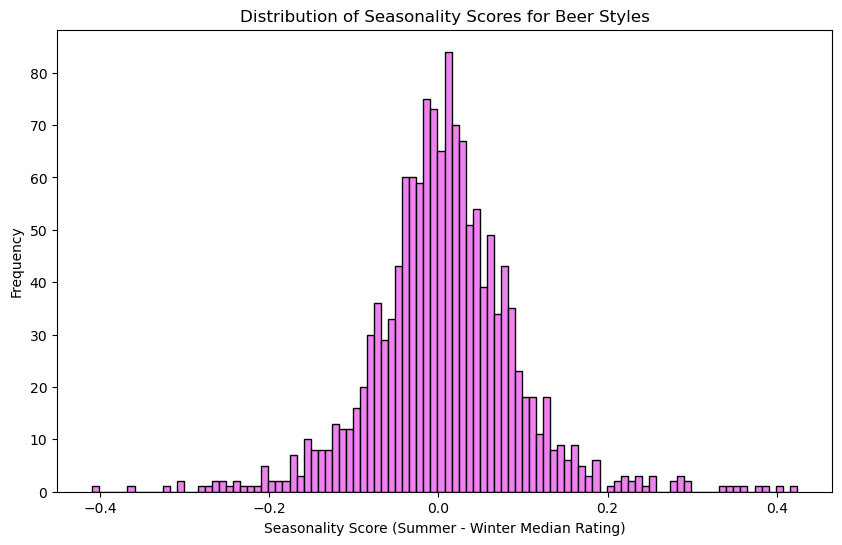

In [ ]:
# Calculate seasonality scores
seasonality_scores = calculate_seasonality_score(df_test, min_reviews=100)

# Plot the histogram of seasonality scores
plt.figure(figsize=(10, 6))
#plt.yscale('log')
plt.hist(seasonality_scores['Seasonality_Score'], bins=100, color='violet', edgecolor='black')
plt.xlabel('Seasonality Score (Summer - Winter Median Rating)')
plt.ylabel('Frequency')
plt.title('Distribution of Seasonality Scores for Beer Styles')
plt.show()

### 1.1 Test if data is normally distributed

In [ ]:
stat, p_value = shapiro(seasonality_scores['Seasonality_Score'])
print(f"Shapiro-Wilk Test: p-value = {p_value}")

if p_value > 0.05:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Shapiro-Wilk Test: p-value = 2.6299021999051924e-19
Data does not look normally distributed (reject H0)


In [ ]:
mean_score = seasonality_scores['Seasonality_Score'].mean()
median_score = seasonality_scores['Seasonality_Score'].median()
skewness_score = skew(seasonality_scores['Seasonality_Score'].dropna())

print("Mean Seasonality Score:", mean_score)
print("Median Seasonality Score:", median_score)
print("Skewness of Seasonality Score:", skewness_score)

Mean Seasonality Score: 0.006637713
Median Seasonality Score: 0.006190776824951172
Skewness of Seasonality Score: 0.21837197883286702


### 1.2 Test if mean is significantly different from 0

In [ ]:
# Assume `seasonality_scores` is the array or Series with your seasonality score data
t_stat, p_value = ttest_1samp(seasonality_scores['Seasonality_Score'], 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # common significance level
if p_value < alpha:
    print("Reject the null hypothesis: The mean seasonality score is significantly different from zero.")
else:
    print("Fail to reject the null hypothesis: The mean seasonality score is not significantly different from zero.")

T-statistic: 2.889312188263239
P-value: 0.0039204364370407415
Reject the null hypothesis: The mean seasonality score is significantly different from zero.


# 2. Beer types seasonality

### Seasonality for beer types : which beer type is the most liked per month?

In [12]:
unique_beer_types = df_test['Style'].unique()

len(unique_beer_types)

104

In [25]:
def top_k_beer_styles(df, k=10, group_by='Month', season_months=None, specific_month=None):
    """
    Returns the top k most popular beer styles based on a specified grouping criterion.
    
    Parameters:
    - df: DataFrame with beer reviews.
    - k: Number of top beer styles to display per group.
    - group_by: How to group the data ('Month', 'Season', 'Day_in_Month', 'Year').
    - season_months: List of month numbers (e.g., [1,2,3]) defining a season (used if group_by='Season').
    - specific_month: Specific month number (1-12) to filter days within that month (used if group_by='Day_in_Month').

    Returns:
    - DataFrame with top k beer styles for each grouping.
    """
    
    # Define grouping criteria based on `group_by`
    if group_by == 'Month':
        df.loc['Period'] = df['Month']
        
    elif group_by == 'Season':
        if season_months is None:
            raise ValueError("Please provide 'season_months' as a list of months (e.g., [1, 2, 3]).")
        df = df[df['Month'].isin(season_months)]
        df.loc['Period'] = f"Season {'-'.join(map(str, season_months))}"
        
    elif group_by == 'Day_in_Month':
        if specific_month is None:
            raise ValueError("Please provide a 'specific_month' (e.g., 1 for January) when grouping by day within a month.")
        df = df[df['Month'] == specific_month]
        df.loc['Period'] = df['Day']  # Group by each day within the specified month
        
    elif group_by == 'Year':
        df.loc['Period'] = df['Year']
        
    else:
        raise ValueError("Invalid group_by option. Choose 'Month', 'Season', 'Day_in_Month', or 'Year'.")

    # Step 1: Group by Period and Style to get total reviews
    grouped = df.groupby(['Period', 'Style']).agg(
        rating_count=('Rating', 'count')
    ).reset_index()

    # Step 2: For each period, find the top k beer styles by total reviews
    top_styles_per_period = (
        grouped.groupby('Period')
        .apply(lambda x: x.nlargest(k, 'rating_count'))
        .reset_index(drop=True)
    )

    return top_styles_per_period

/var/folders/ym/l2ghjvys50qctty39wm955gm0000gn/T/ipykernel_59735/2635140772.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc['Period'] = df['Month']
/var/folders/ym/l2ghjvys50qctty39wm955gm0000gn/T/ipykernel_59735/2635140772.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['Period'] = df['Month']
/var/folders/ym/l2ghjvys50qctty39wm955gm0000gn/T/ipykernel_59735/2635140772.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns

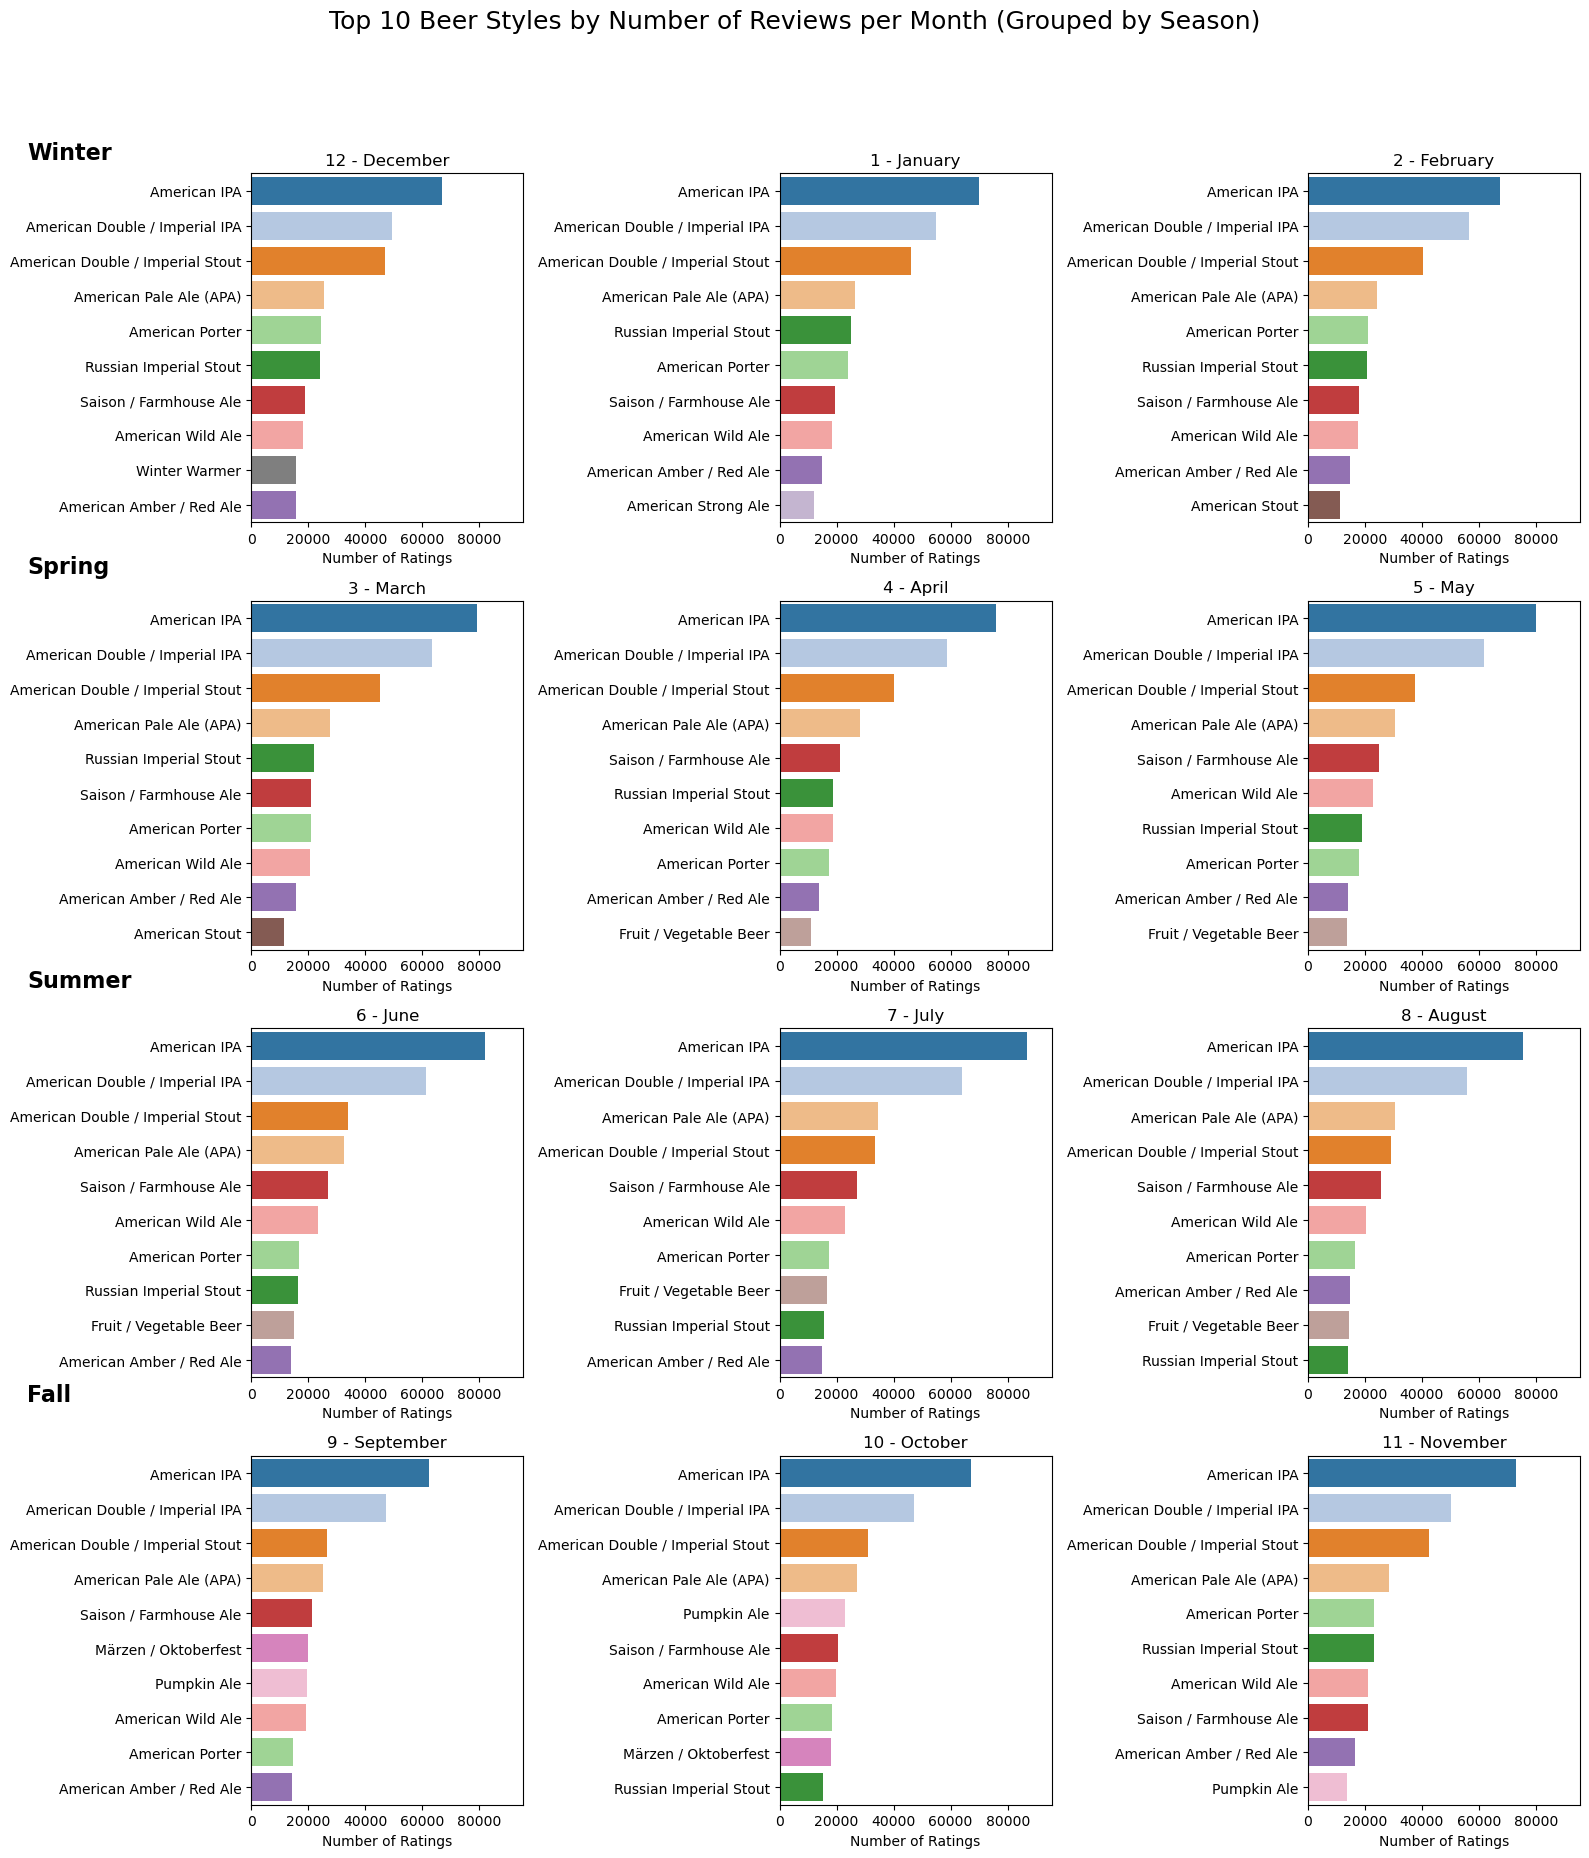

In [26]:
# Get top 10 styles per month
top_styles_per_month = top_k_beer_styles(df=df_test, k=10, group_by='Month')

# Define the seasons and their corresponding months
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a color palette with a consistent color per beer style
unique_styles = top_styles_per_month['Style'].unique()
palette = sns.color_palette("tab20", len(unique_styles))
style_colors = dict(zip(unique_styles, palette))  # Map each style to a unique color

# Calculate a global maximum for the x-axis limit
max_rating_count = top_styles_per_month['rating_count'].max()

# Initialize the plot with a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(16, 18), constrained_layout=True)

# Loop through each season and each month within the season
for i, (season, months) in enumerate(seasons.items()):
    # Add a large subtitle for the season on the left side
    fig.text(0.02, 0.95 - i * 0.23, season, ha='left', fontsize=16, fontweight='bold', va='center')
    
    for j, month in enumerate(months):
        # Filter data for the specific month
        month_data = top_styles_per_month[top_styles_per_month['Period'] == month]
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        sns.barplot(
            data=month_data,
            y='Style',
            x='rating_count',
            palette=style_colors,  # Use the consistent color palette
            ax=ax
        )
        
        # Set the title and labels
        ax.set_title(f"{month} - {pd.to_datetime(f'2023-{month:02d}-01').strftime('%B')}", fontsize=12)  # Display month name
        ax.set_xlabel('Number of Ratings')
        ax.set_ylabel('')  # Remove redundant y-axis label for cleaner look
        ax.set_xlim(0, max_rating_count * 1.1)  # Set a fixed x-axis limit for all plots
        
        # Optional: Adjust y-axis ticks for readability
        ax.tick_params(axis='y', labelsize=10)

# Set the overall title and adjust layout
plt.suptitle("Top 10 Beer Styles by Number of Reviews per Month (Grouped by Season)", fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title and subtitles
plt.show()


# 4. Degree of seasonality depending on latitude

Degeree of seasonality isnt defined by litterature, so we would have to define it to answer this question  
--> seasonality shouldnt depend only on latitude, because earth axial tilt  
--> should also depend on **day length and temperature** (but these infos we can obtain with weather infos)

assumption that one country or state latitude 

--> found two datasets with latitudes, put them into CSV file  
https://developers.google.com/public-data/docs/canonical/states_csv  
https://developers.google.com/public-data/docs/canonical/countries_csv  
https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state?resource=download

